# Issues need to be solved:
1. Potential array interpolation.

    For a 3-dimensional interpolation, there could be also **_nearest_, _linear_ and _cubic_** methods. [Wiki on multivariate interpolation.](https://en.wikipedia.org/wiki/Interpolation)  [Scipy.interpolate](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) provides several functions for high dimension interpolation. [RegularGridInterpolation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator) only provides linear and nearest methods, which might be insufficient for our field potential interpolation. [GridData function](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) provides (1-d or 2-d) cubic interpolation, which might match our request.
    
2. Units.

    In the trajectory calculation, length in unit of mm, time in unit of us, velocity in unit of mm/us, charge in unit of e, mass in unit of atomic unit mass 
    
3. Trajectories iteration or 2nd [ODE solution](https://docs.scipy.org/doc/scipy-0.13.0/reference/integrate.html)
    
    [ode](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode)
    
    [odein](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.odeint.html)
    
    Vector function integration using [Runge-Kutta methods](https://rosettacode.org/wiki/Runge-Kutta_method) or Euler
    Should the gradient force be calculated everytime iteration is made or should it be calculated at once.
    
    
## To-Do
1. Integration method problem. [Change iteration algorithms](http://stackoverflow.com/questions/19779217/need-help-solving-a-second-order-non-linear-ode-in-python)
Runge-Kutta method?

2. Interpolation and gradient calculation step.

3. Change electrodes potentials to the current setup. Single ion trajectory as function of time. in Runge-Kutta integration.

4. Simulate detected signal.

5. Time resolution

6. Define MCP detection area and ion stop condition

11.08: When doing Gradient/Electric force calculation, spatial step is important

### Import potentials and coordinates from HDF5 file

In [54]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [77]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [78]:
for name in f:
    print name

Coordinates
Potential Arrays
iselectrode


In [79]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [80]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [81]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [82]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

### Calculate single ion trajectory

Define velocity iteration function and trajectory iteration function for single ion.

MCP detector plane

In [83]:
mx=np.arange(-8,8,0.1)
my=np.arange(-8,8,0.1)

points=np.array([])

for i in mx:
    for j in my:
        if (i**2+j**2)<= 7.25**2:
            points=np.append(points,([i,j,3]))

points=points.reshape((len(points)/3,3))

phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

MCPgrid=np.array([tmatrix.dot(i) for i in points])*2 + [247,205,214]
MCP=MCPgrid/2

In [84]:
#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

<IPython.core.display.Javascript object>


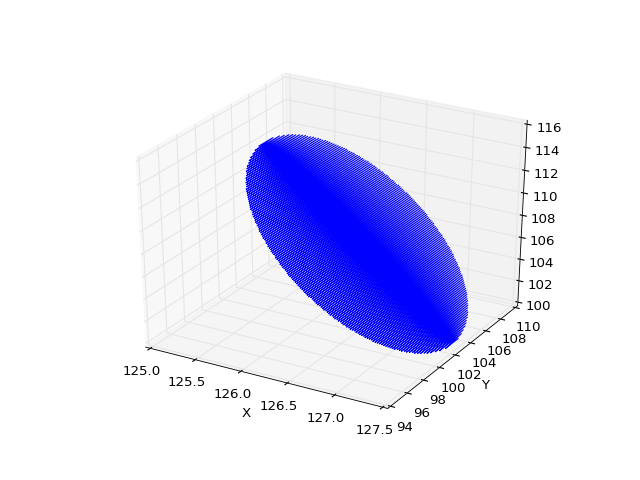

In [10]:
%matplotlib notebook
mcpplot=plt.figure()
mp=mcpplot.add_subplot(111,projection='3d')
mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [85]:
#single ion's position and velocity iteration functions

def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

def Gradientforce(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def ion_exist(r):
    ion_number=len(r)
    ion_condition=[0 for i in range(ion_number)]
    for j in range(ion_number):
        r_ionj=r[j]
        ion_condition[j]=(r_ionj>[x[1],y[1],z[1]]).all() and (r_ionj<[x[-2],y[-2],z[-2]]).all() and (r_ionj[2]-np.tan(phi)*r_ionj[0]<=c)
        
    return ion_condition

"""
#Function to calculate two ions coulombic force
def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
"""
    

def VCoul(index,r_iter,ion_condition):
    r_origin=r_iter[index]
    ion_number=len(r_iter)
    force=np.zeros((1,3))
    for i in range(ion_number):
        if (i!=index and ion_condition[i]):
            distance=np.linalg.norm(r_origin - r_iter[i])
            coulf=1.595 * 1.e-6 / distance**2
            force += (r_origin - r_iter[i]) * coulf/distance
    return force[0]
    
    

def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= np.array([np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t])
    return r_new



def nstop(r):
    xx=r[0]
    zz=r[2]
    if (zz+np.tan(phi)*xx)< c :
        return True
    else:
        return False

In [86]:
def trajectory2(r_init,v_init,dt):
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=Gradientforce(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>20:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

Test ion_exist() and VCoul() functions

In [87]:
r_test=np.zeros((10,3))
r0=np.array([94.5,102.5,54.5])
for i in range(len(r_test)):
    r_test[i]=r0 + [10*i, 0,0]

In [88]:
condition=ion_exist(r_test)
print condition
VCoul(1,r_test,condition)

[True, True, True, True, False, False, False, False, False, False]


array([ -3.98750000e-09,   0.00000000e+00,   0.00000000e+00])

In [49]:
any(condition)

True

**Distance step when calculating gradient has significant fluence on the trajectories**

In [89]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]

In [123]:
def trajectories_ions(r_init,v_init,dt):
    ion_number=len(r_init)
    count=np.zeros(ion_number)
    r_iter=np.zeros((ion_number,3))
    r_n=np.zeros((ion_number,3))
    r_iter=r_init
    v_iter=v_init
    r_n=np.zeros((ion_number,3))
    
    #no appending?
    global condition
    condition = ion_exist(r_iter)
    while any(condition):
        # while loop condition: ion still in effective volume, and not hit the plane
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        for i in range(ion_number):
            if condition[i]:
                r_n[i]=np.array(r_iter[i])
                v_iter[i]=Gradientforce(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr) + VCoul(i,r_iter,condition) * dt
                r_iter[i]=R(r_iter[i],v_iter[i],dt)
                count[i] += 1
            #print r_iter[0]
        
        if max(count * dt)>15:
            break
            
        condition=ion_exist(r_iter)
        
    #map coordinates into detector plane coordinate
    r_final=np.zeros((ion_number,3))
    for k in range(ion_number):
        r_final[k]=cross_ratio(r_n[k],r_iter[k],count[k],dt)
    v_final=v_iter
    #print r_final
    #displacement=np.array(r_new1) - np.array(r_new2)
    ionsituation=np.concatenate((r_final,v_final),axis=1)
    #print r_final
    return r_final

In [91]:
import time

In [121]:
# 97.5  102.5   66.
xc=np.linspace(95.8 - 0.05,95.8 + 0.05,21)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(66. - 0.01,66. + 0.01,5)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((len(xc)*len(yc)*len(zc),3))
ind=0
tstart=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            ind += 1

tend=time.time()
print tend-tstart
print len(startpoints)

#startpoints

0.00500011444092
525


In [114]:
singlefinals=np.zeros((len(startpoints),3))
v0=np.array([0,0,0])

for i in range(len(startpoints)):
    [singlefinals[i],v[i]]=trajectory2(startpoints[i],v0,dt)
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


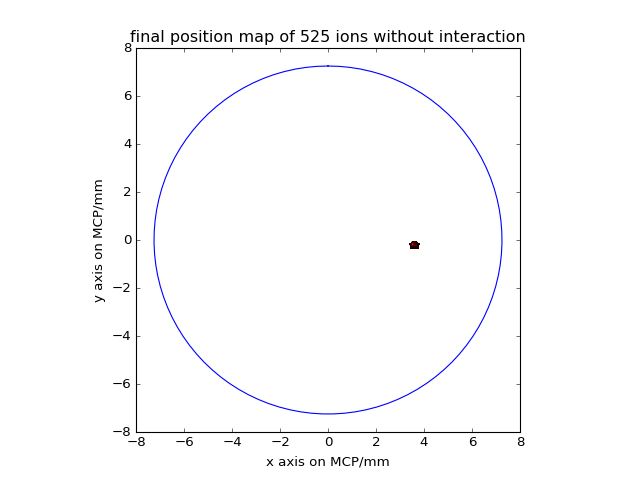

In [115]:
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(singlefinals[:,0],singlefinals[:,1],'r*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
plt.title("final position map of 525 ions without interaction")
plt.show()

<IPython.core.display.Javascript object>


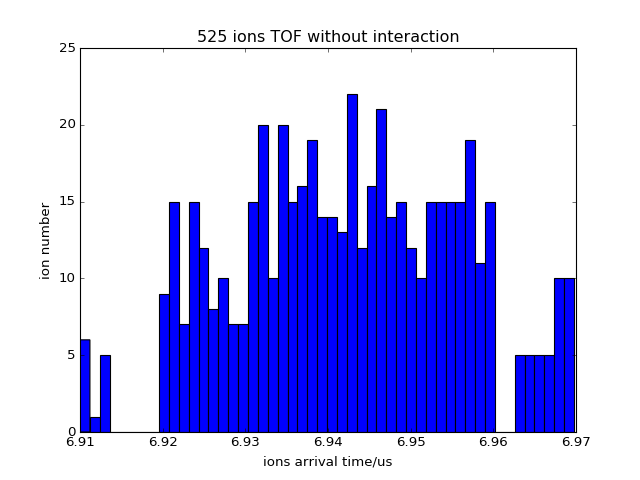

In [117]:
count, bins, ignored = plt.hist(singlefinals[:,2], 50)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("525 ions TOF without interaction")
plt.show()

In [ ]:
tstart=time.time()
finalpoints=trajectories_ions(startpoints,v,dt)
tend=time.time()
print tend-tstart

In [ ]:
finalpoints.shape

In [ ]:
finalpoints_good=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 7.25]
finalpoints_good.shape

In [ ]:
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(finalpoints_good[:,0],finalpoints_good[:,1],'*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
plt.title("final position map of 513/525 ions with interaction")
plt.show()

<IPython.core.display.Javascript object>


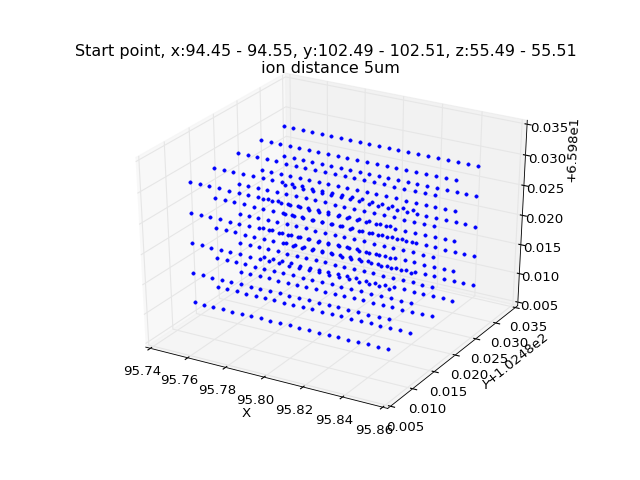

In [122]:
%matplotlib notebook
mcpplot=plt.figure()
mp=mcpplot.add_subplot(111,projection='3d')
#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
mp.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],'.')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")
plt.show()

<IPython.core.display.Javascript object>


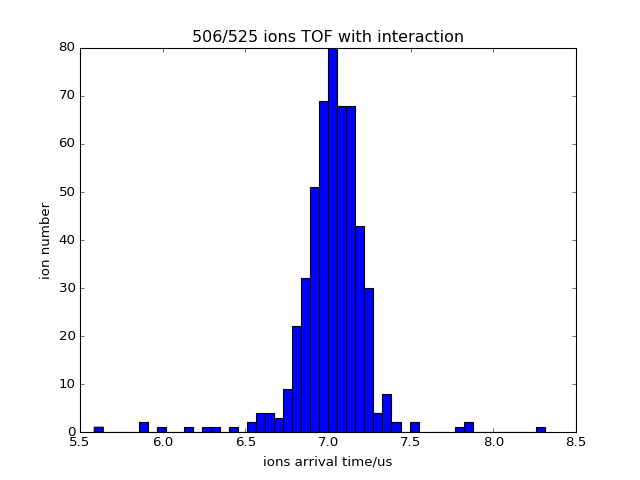

In [111]:
count, bins, ignored = plt.hist(finalpoints_good[:,2], 50)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("506/525 ions TOF with interaction")
plt.show()

In [74]:
count

array([ 19.22836921,  13.45985845,   9.61418461,  15.38269537,
         9.61418461,   0.        ,   9.61418461,   7.69134769,
         1.92283692,   7.69134769,  32.68822766,  26.9197169 ,
        26.9197169 ,  30.76539074,  19.22836921,  23.07404306,
        19.22836921,  24.99687998,  11.53702153,  34.61106458,
        26.9197169 ,  30.76539074,  28.84255382,  38.45673843,
        38.45673843,  21.15120613,  30.76539074,  38.45673843,
        28.84255382,  24.99687998,  13.45985845,  15.38269537,
        24.99687998,  21.15120613,  26.9197169 ,  28.84255382,
        19.22836921,  34.61106458,  38.45673843,  19.22836921,
         9.61418461,   0.        ,   9.61418461,   7.69134769,
         1.92283692,  19.22836921,  17.30553229,   1.92283692,
        19.22836921,  28.84255382])

In [237]:
fcoul=h5py.File('TOF and final position with Coulombic interaction.hdf5','w')

In [238]:
startcoul=fcoul.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)

In [265]:
startcoul[...]=startpoints

In [239]:
finalcoul=fcoul.create_dataset("finalpoints",(finalpoints.shape),dtype=np.float64)
finalcoul[...]=finalpoints

In [27]:
fnocoul=h5py.File('TOF and final position without Couloumbic interaction.hdf5','w')

In [28]:
single=fnocoul.create_dataset("single ions final position",(singlefinals.shape),dtype=np.float64)

In [162]:
v0=np.zeros((100,3))
r0=np.zeros((100,3))
for k in range(len(r0)):
    r0[k]=[94.5 + k*0.1,102.5,54.5]
#r0=np.array([[94.5,102.5,54.5],[94.6,102.5,54.5],[94.7,102.5,54.5],[94.8,102.5,54.5]])
tstart=time.time()
r=trajectories_ions(r0,v0,dt)
tend=time.time()
print r,tend-tstart

[[ 0.18829336  0.07690852  4.45376038]
 [ 0.05391135  0.08748673  4.44320879]
 [-0.07262028  0.0979      4.43302534]
 [-0.19288363  0.10811478  4.42307097]
 [-0.30193144  0.11810359  4.41349445]
 [-0.3992394   0.12778341  4.40436299]
 [-0.48707629  0.13710076  4.39575847]
 [-0.56709355  0.14628521  4.38757263]
 [-0.6336089   0.15531062  4.37977038]
 [-0.68683687  0.16414294  4.37236991]
 [-0.719545    0.17271789  4.36547806]
 [-0.73730465  0.18100197  4.35924184]
 [-0.75769785  0.1892606   4.35392753]
 [-0.76707881  0.19739203  4.34897964]
 [-0.78482101  0.20536316  4.34435681]
 [-0.80398912  0.21300716  4.3395068 ]
 [-0.83763186  0.22029878  4.33458917]
 [-0.88079716  0.22740469  4.329504  ]
 [-0.93059264  0.23418254  4.32354854]
 [-0.99867372  0.24077771  4.31781273]
 [-1.07005457  0.24711208  4.31219076]
 [-1.15118889  0.25299205  4.30590794]
 [-1.23979883  0.25881449  4.30018954]
 [-1.32781134  0.2644488   4.29437629]
 [-1.42037083  0.26988538  4.28862454]
 [-1.50727853  0.27515801

### Coulomb interaction influence

In [79]:
#Starting point r0 and initial velocity v0
r0=np.array([94.5,102.5,55.5])
v0=np.array([0,0,0])
[f10,v10]=trajectory2(r0,v0,dt)
f10,v10

([0.27608091170657961, 0.069906204468793476, 4.4917916905373669],
 array([ 62.59098621,   0.063188  ,  12.78745611]))

In [83]:
type(f10)

list

In [228]:
xc=np.linspace(94.5 - 0.05,94.5 + 0.05,21)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(55.5 - 0.01,55.5 + 0.01,5)
print xc
print yc
print zc

[ 94.45   94.455  94.46   94.465  94.47   94.475  94.48   94.485  94.49
  94.495  94.5    94.505  94.51   94.515  94.52   94.525  94.53   94.535
  94.54   94.545  94.55 ]
[ 102.49   102.495  102.5    102.505  102.51 ]
[ 55.49   55.495  55.5    55.505  55.51 ]


In [40]:
r0=np.array([102.5,102.5,65.])
v0=np.array([0.,0.,0.])

In [112]:
finalpoints_good.shape

(513L, 3L)